In [1]:
#import required dependencies
import math
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

In [3]:

SIGMA = 0.0035
SIGMA_SQR = SIGMA * SIGMA
class BFAnalyzer:
    def __init__(self):
        self.__frequency = [float(0)]*256#byteFrequencyarray
    def compute(self, text):
        for i in range(256):
            self.__frequency[i]=text.count(chr(i))#frequencyCalculation
        return self
    def normalize(self):
        try:
            norm = max(self.__frequency)
            self.__frequency =  list(map(lambda x: x / norm, self.__frequency))#Normalizing data
        except:
            pass
        return self
    def compand(self):
        B = 1.5
        self.__frequency =  list(map(lambda x: x ** ( 1 / B), self.__frequency))#Comapnding data
        return self
    def frequency(self):
        return np.array(self.__frequency)
    def __str__(self):
        return ",".join(map(str, self.__frequency))
class BFFileprint:
    def __init__(self,signatures):
        self.__fileprint=[float(0)]*256
        self.__signatures=signatures
    def computeFileprint(self):
        tot=len(self.__signatures)
        for i in range(256):
            self.__fileprint[i]=(sum([x[i] for x in self.__signatures])/tot)#Averaging all signatures for filePrint
        return self
    def fileprint(self):
        return self.__fileprint
    
#ByteFrequencyCorrelator calucates correlation for each file with corresponding fileType Fingerprint
class ByteFrequencyCorrelator:
    def __init__(self,filePrint):
        self.filePrint = filePrint
    def correlate(self, signature):
        self.cmpSignature = signature
        self.correlation = [None] * 256
        for i in range(256):
            diff = self.cmpSignature[i] - self.baseSignature[i]
            exp = ( -1 * diff * diff ) / ( 2 * SIGMA_SQR )
            self.correlation[i] = math.exp(exp)
        return self.correlation
#ByteFrequencyCrossCorrelator calculates correlation for every byte with every other byte
class BFCrossCorrelator:
    def __init__(self, baseSignature):
        self.baseSignature = baseSignature
    def correlate(self):
        self.correlation = Matrix = [[0 for x in range(256)] for x in range(256)]
        for i in range(256):
            for j in range(i):
                freqDiff = ( self.baseSignature[i] - self.baseSignature[j] )
                exp = ( -1 * freqDiff * freqDiff ) / ( 2 * SIGMA_SQR )
                self.correlation[i][j] = freqDiff
                self.correlation[j][i] = math.exp(exp)
        return self.correlation
worksample='/home/surya/blueOptima/worksample_data/'
data={}
for folder in os.listdir(worksample):
    temp=[]
    for file in os.listdir(worksample+folder):
        with open(worksample+folder+'/'+file) as textfile:
            try:
                text=textfile.read()
                analyzer=BFAnalyzer()
                signature=analyzer.compute(text).compand().normalize().frequency()
                temp.append(signature)
            except:
                pass
    data[folder]=temp
#signatures generated for every file and stored in data dictionary where keys are file type and values are signatures
#Compute FilePrint for each filetype from generated signatures
filePrints={}
for key,value in data.items():
    generator=BFFileprint(value)
    filePrints[key]=generator.computeFileprint().fileprint()
    

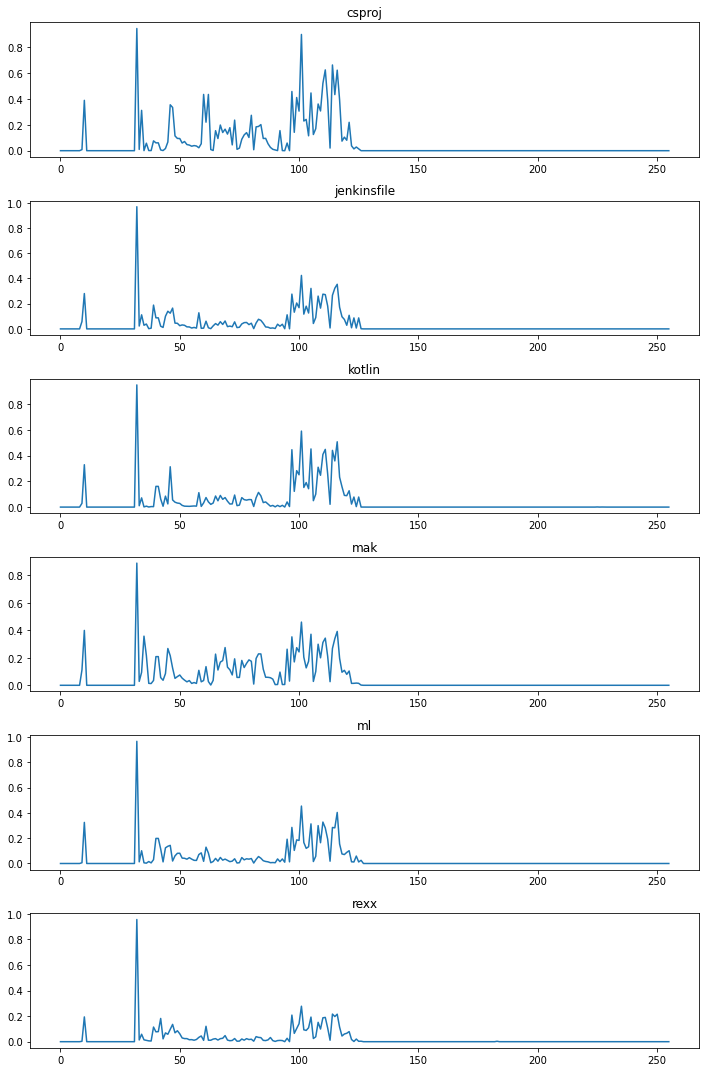

In [3]:

x=[i for i in range(256)]
#plt.figure(figsize=(10,60))
fig, axs = plt.subplots(6, 1,figsize=(10,15))
axs[0].plot(x,filePrints['csproj'] )
axs[0].set_title("csproj")
axs[1].plot(x,filePrints['jenkinsfile'])
axs[1].set_title("jenkinsfile")
axs[2].plot(x,filePrints['kt'])
axs[2].set_title("kotlin")
axs[3].plot(x,filePrints['mak'])
axs[3].set_title("mak")
axs[4].plot(x, filePrints['ml'])
axs[4].set_title("ml")
axs[5].plot(x,filePrints['rexx'])
axs[5].set_title('rexx')
fig.tight_layout()

In [4]:
X=[]
Y=[]
numy=[]
i=1
for key,value in data.items():
    y=[key]*len(value)
    X+=value
    numy+=[i]*len(value)
    Y+=y
    i+=1
XT=pd.DataFrame(X,columns=[i for i in range(256)])
XT.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311904,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## principal component analysis

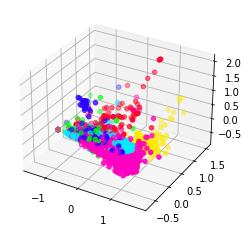

In [5]:

pca=PCA(n_components=3)
comps=pca.fit_transform(XT)
PCADF = pd.DataFrame(data =comps,columns = ['pc1', 'pc2','pc3'])
ax = plt.axes(projection='3d')
ax.scatter3D(PCADF['pc1'],PCADF['pc2'],PCADF['pc3'], c=numy, cmap='gist_rainbow');

## Kernel PCA

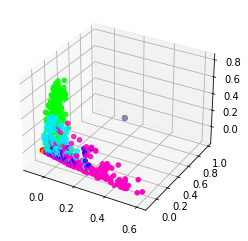

In [6]:

kpca = KernelPCA(kernel="rbf", gamma=15, n_components=3)
kcomps=kpca.fit_transform(XT)
KPCADF = pd.DataFrame(data =kcomps,columns = ['pc1', 'pc2','pc3'])
ax = plt.axes(projection='3d')
ax.scatter3D(KPCADF['pc3'],KPCADF['pc2'],KPCADF['pc1'], c=numy, cmap='gist_rainbow');

## Linear Discriminant Analysis

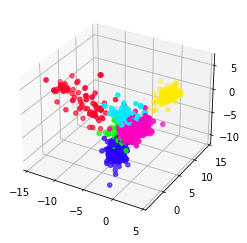

In [7]:

lda=LinearDiscriminantAnalysis(n_components=3)
comps=lda.fit(XT,numy).transform(XT)
LDADF = pd.DataFrame(data =comps,columns = ['pc1', 'pc2','pc3'])
ax = plt.axes(projection='3d')
ax.scatter3D(LDADF['pc2'],LDADF['pc1'],LDADF['pc3'], c=numy, cmap='gist_rainbow');

## NMF  Non-negative Matrix Factorization

/home/surya/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


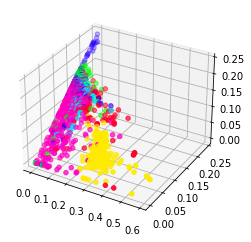

In [8]:

nmf=NMF(n_components=3,random_state=1)
comps=nmf.fit_transform(XT)
NMFDF = pd.DataFrame(data =comps,columns = ['pc1', 'pc2','pc3'])
ax = plt.axes(projection='3d')
ax.scatter3D(NMFDF['pc3'],NMFDF['pc2'],NMFDF['pc2'], c=numy, cmap='gist_rainbow');

## Truncated Singular Value Decomposition

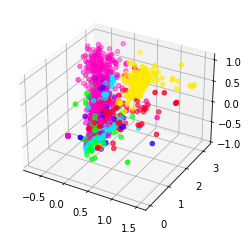

In [9]:

tsvd=TruncatedSVD(n_components=3)
features_sparse=csr_matrix(XT)
comps=tsvd.fit(features_sparse).transform(features_sparse)
TSVDDF = pd.DataFrame(data =comps,columns = ['pc1', 'pc2','pc3'])
ax = plt.axes(projection='3d')
ax.scatter3D(TSVDDF['pc3'],TSVDDF['pc1'],TSVDDF['pc2'], c=numy, cmap='gist_rainbow');

In [ ]:
PCADF['target']=numy
PCADF['class']=Y
KPCADF['target']=numy
KPCADF['class']=Y
LDADF['target']=numy
LDADF['class']=Y
NMFDF['target']=numy
NMFDF['class']=Y
TSVDDF['target']=numy
TSVDDF['class']=Y
PCADF.to_csv('PCADF.csv')
KPCADF.to_csv('KPCADF.csv')
LDADF.to_csv('LDADF.csv')
NMFDF.to_csv('NMFDF.csv')
TSVDDF.to_csv('TSVDDF.csv')

### modelling on PCA data

In [10]:

data=pd.read_csv('PCADF.csv')
data=data.drop(['Unnamed: 0','class'],axis=1)
target=data['target']
data=data.drop('target',axis=1)
print(data.head())
print()
xtrain,xtest,ytrain,ytest=train_test_split(data,target,test_size=0.2)
#standar scaler to scale the data properly
scaler = StandardScaler()
Xtrain = scaler.fit_transform(xtrain)
Xtest = scaler.transform(xtest)
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'],'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(Xtrain, ytrain)
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Ypred = final_model.predict(Xtest)
print(confusion_matrix(ytest,Ypred))
print("\n")
print(classification_report(ytest,Ypred))

print("Training set score for SVM: %f" % final_model.score(Xtrain , ytrain))
print("Testing  set score for SVM: %f" % final_model.score(Xtest  , ytest ))

        pc1       pc2       pc3
0  0.361704  0.284945  0.419510
1 -0.963340  0.214313  0.042745
2  0.605003  0.447530  0.665202
3  0.289275  0.466657  0.509933
4  0.647713  1.147260  1.627098

Best score for training data: 0.7035583776547633 

Best C: 1000 

Best Kernel: rbf 

Best Gamma: 0.001 

[[  8   0   1   5   0   3]
 [  0  52   1   0   0   0]
 [  0   0  39   1   3  10]
 [  1   0  22   7   1  16]
 [  1   0   5   2  13  36]
 [  1   0   6   2   1 179]]


              precision    recall  f1-score   support

           1       0.73      0.47      0.57        17
           2       1.00      0.98      0.99        53
           3       0.53      0.74      0.61        53
           4       0.41      0.15      0.22        47
           5       0.72      0.23      0.35        57
           6       0.73      0.95      0.83       189

    accuracy                           0.72       416
   macro avg       0.69      0.59      0.59       416
weighted avg       0.70      0.72      0.68      

### modelling on KPCA data

In [2]:

data=pd.read_csv('KPCADF.csv')
data=data.drop(['Unnamed: 0','class'],axis=1)
target=data['target']
data=data.drop('target',axis=1)
print(data.head())
print()
xtrain,xtest,ytrain,ytest=train_test_split(data,target,test_size=0.2)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(xtrain)
Xtest = scaler.transform(xtest)
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'],'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(Xtrain, ytrain)
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Ypred = final_model.predict(Xtest)
print(confusion_matrix(ytest,Ypred))
print("\n")
print(classification_report(ytest,Ypred))

print("Training set score for SVM: %f" % final_model.score(Xtrain , ytrain))
print("Testing  set score for SVM: %f" % final_model.score(Xtest  , ytest ))

        pc1       pc2       pc3
0 -0.045522 -0.011030 -0.049052
1 -0.046236 -0.014287 -0.076627
2 -0.045497 -0.011021 -0.048993
3 -0.045496 -0.011021 -0.048992
4 -0.045547 -0.011039 -0.049112

Best score for training data: 0.5736531712435328 

Best C: 1000 

Best Kernel: linear 

Best Gamma: 0.001 

[[  0   3   0   0   0  11]
 [  0  14   1   0   0  32]
 [  0   1  28   4   0  23]
 [  0   2   8  10   0  24]
 [  0   0   0   1   0  58]
 [  0   3   0   5   0 188]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.61      0.30      0.40        47
           3       0.76      0.50      0.60        56
           4       0.50      0.23      0.31        44
           5       0.00      0.00      0.00        59
           6       0.56      0.96      0.71       196

    accuracy                           0.58       416
   macro avg       0.40      0.33      0.34       416
weighted avg       0.49      0.58      0.49   

/home/surya/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### modelling on LDA data

In [5]:

data=pd.read_csv('LDADF.csv')
data=data.drop(['Unnamed: 0','class'],axis=1)
target=data['target']
data=data.drop('target',axis=1)
print(data.head())
print()
xtrain,xtest,ytrain,ytest=train_test_split(data,target,test_size=0.2)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(xtrain)
Xtest = scaler.transform(xtest)
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'],'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(Xtrain, ytrain)
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Ypred = final_model.predict(Xtest)
print(confusion_matrix(ytest,Ypred))
print("\n")
print(classification_report(ytest,Ypred))

print("Training set score for SVM: %f" % final_model.score(Xtrain , ytrain))
print("Testing  set score for SVM: %f" % final_model.score(Xtest  , ytest ))

        pc1       pc2       pc3
0  0.152160 -6.731869  3.355500
1 -0.893968 -4.666330  2.271738
2 -2.980149 -9.230017  1.810825
3 -0.446289 -6.158868  2.690923
4  1.402740 -8.613285  3.925147

Best score for training data: 0.9049929447519809 

Best C: 100 

Best Kernel: linear 

Best Gamma: 0.001 

[[ 20   0   1   0   0   0]
 [  0  44   1   0   0   1]
 [  2   0  24   2   3   5]
 [  0   0   0  44   0  10]
 [  0   0   4   0  50   1]
 [  0   0   1   5   0 198]]


              precision    recall  f1-score   support

           1       0.91      0.95      0.93        21
           2       1.00      0.96      0.98        46
           3       0.77      0.67      0.72        36
           4       0.86      0.81      0.84        54
           5       0.94      0.91      0.93        55
           6       0.92      0.97      0.95       204

    accuracy                           0.91       416
   macro avg       0.90      0.88      0.89       416
weighted avg       0.91      0.91      0.91    

### modelling on NMF data

In [2]:

data=pd.read_csv('NMFDF.csv')
data=data.drop(['Unnamed: 0','class'],axis=1)
target=data['target']
data=data.drop('target',axis=1)
print(data.head())
print()
xtrain,xtest,ytrain,ytest=train_test_split(data,target,test_size=0.2)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(xtrain)
Xtest = scaler.transform(xtest)
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'],'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(Xtrain, ytrain)
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Ypred = final_model.predict(Xtest)
print(confusion_matrix(ytest,Ypred))
print("\n")
print(classification_report(ytest,Ypred))

print("Training set score for SVM: %f" % final_model.score(Xtrain , ytrain))
print("Testing  set score for SVM: %f" % final_model.score(Xtest  , ytest ))

        pc1       pc2       pc3
0  0.115479  0.112404  0.168154
1  0.000522  0.156411  0.045961
2  0.112766  0.100498  0.233695
3  0.077290  0.125570  0.212504
4  0.025050  0.000000  0.437126

Best score for training data: 0.6776927529939578 

Best C: 1000 

Best Kernel: rbf 

Best Gamma: 0.001 

[[ 14   7   1   0   0   4]
 [  3  45   1   0   0   0]
 [  1   0  32   1   0  13]
 [  1   0  16   0   0  19]
 [  1   0   5   0   5  47]
 [  1   2   4   1   0 192]]


              precision    recall  f1-score   support

           1       0.67      0.54      0.60        26
           2       0.83      0.92      0.87        49
           3       0.54      0.68      0.60        47
           4       0.00      0.00      0.00        36
           5       1.00      0.09      0.16        58
           6       0.70      0.96      0.81       200

    accuracy                           0.69       416
   macro avg       0.62      0.53      0.51       416
weighted avg       0.68      0.69      0.62      

### modelling on TSVD data

In [2]:

data=pd.read_csv('TSVDDF.csv')
data=data.drop(['Unnamed: 0','class'],axis=1)
target=data['target']
data=data.drop('target',axis=1)
print(data.head())
print()
xtrain,xtest,ytrain,ytest=train_test_split(data,target,test_size=0.2)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(xtrain)
Xtest = scaler.transform(xtest)
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'],'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(Xtrain, ytrain)
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Ypred = final_model.predict(Xtest)
print(confusion_matrix(ytest,Ypred))
print("\n")
print(classification_report(ytest,Ypred))

print("Training set score for SVM: %f" % final_model.score(Xtrain , ytrain))
print("Testing  set score for SVM: %f" % final_model.score(Xtest  , ytest ))

        pc1       pc2       pc3
0  2.110815  0.018907  0.306479
1  0.934007 -0.573752  0.243466
2  2.325690  0.128448  0.474257
3  2.088301 -0.082215  0.504179
4  2.109241  0.557340  1.153282

Best score for training data: 0.6776909439560042 

Best C: 1000 

Best Kernel: rbf 

Best Gamma: 0.001 

[[ 10   2   3   0   0   3]
 [  1  37   0   0   0   1]
 [  1   0  48   1   1   5]
 [  2   0  26   1   0  17]
 [  2   0   7   0   7  30]
 [  2   2   4   0   0 203]]


              precision    recall  f1-score   support

           1       0.56      0.56      0.56        18
           2       0.90      0.95      0.92        39
           3       0.55      0.86      0.67        56
           4       0.50      0.02      0.04        46
           5       0.88      0.15      0.26        46
           6       0.78      0.96      0.86       211

    accuracy                           0.74       416
   macro avg       0.69      0.58      0.55       416
weighted avg       0.73      0.74      0.67      